In [ ]:
import numpy as np

import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random


In [ ]:
from google.colab import drive
drive.mount("/content/Gdrive")

Mounted at /content/Gdrive


In [ ]:
!pip install unrar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install rarfile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!unrar x cats_vs_dogs.rar #распаковываем архив


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from cats_vs_dogs.rar


Would you like to replace the existing file PetImages/Cat/0.jpg
 12213 bytes, modified on 2017-02-10 09:54
with a new one
 12213 bytes, modified on 2017-02-10 09:54

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit Q

Program aborted


In [ ]:
!ls PetImages

Cat  Dog


##Task 2
Цель: сделать классификатор изображений на основе сверточных сетей и Transfer learning.

1. Изучите предоставленные материалы. Загрузите и подготовьте данные.
2. Реализовать классификатор для котов и собак на основе [VGG16](https://arxiv.org/pdf/1409.1556.pdf) с помощью Transfer learning. Данные лежат здесь: [https://www.kaggle.com/c/dogs-vs-cats](https://www.kaggle.com/c/dogs-vs-cats). Также можно использовать другую задачу классификации изображений и другой датасет с изображениями (кроме примера).
3. Выполнить аугментацию данных, сделать тонкую настройку сети (fine tuning). Сравнить результаты до и после этих операций, описать выводы.
4. Использовать отличную от VGG предобученную сеть, изучить публикацию по ней, проанализировать, аргументировать выбор.

In [ ]:
import os
#если изображение не получится перекодировать в jfif формат, то удалить
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [ ]:
image_size = (80, 80) #фотографии будут обрабатываться в разрешении 80x80
batch_size = 64

train_ds = tf.keras.preprocessing.image_dataset_from_directory( #генерируем обучающую выборку из изображений в директории
    "PetImages",
    validation_split=0.2, #тестовая часть
    subset="training",
    seed=1450, #перетасовка выборки
    image_size=image_size,  
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory( #генерируем тестовую выборку из изображений в директории
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1450,
    image_size=image_size,
    batch_size=batch_size,
)

Found 1877 files belonging to 2 classes.
Using 1502 files for training.
Found 1877 files belonging to 2 classes.
Using 375 files for validation.


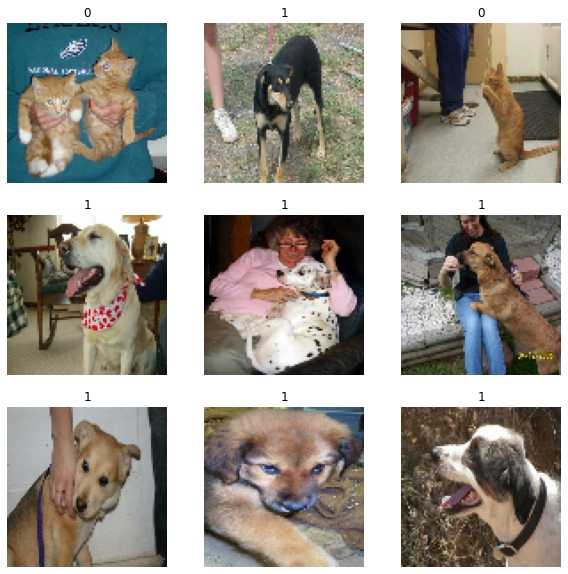

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10)) #котам присуждаем метку 0, собакам - 1
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

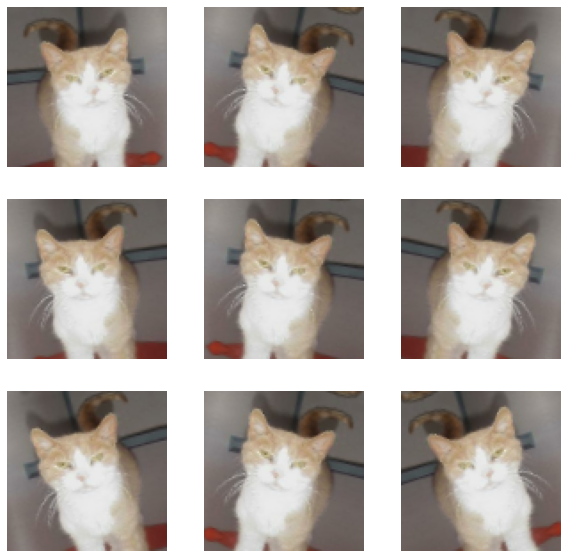

In [ ]:
plt.figure(figsize=(10, 10)) 
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
train_ds = train_ds.prefetch(buffer_size=32) #Большинство конвейеров ввода набора данных должны 
#заканчиваться вызовом предварительной выборки. Это позволяет подготавливать последующие элементы во время обработки текущего элемента. 
#Это часто улучшает задержку и пропускную способность за счет использования дополнительной памяти для хранения предварительно выбранных элементов.
val_ds = val_ds.prefetch(buffer_size=32)

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

 
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x) # слой 2D свёртки создает ядро свертки, которое свертывается с входными данными слоя для получения тензора выходных данных
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)  
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x   
    for size in [128]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x) #Разделяемая по глубине 2D-свертка.
        x = layers.BatchNormalization()(x)

        x = layers.Activation("sigmoid")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
    

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x) #операция объединения двухмерных пространственных данных.
        #Понижает входные данные по его пространственным размерам (высоте и ширине), 
        #принимая максимальное значение в окне ввода (размер которого определяется параметром pool_size) для каждого канала ввода. 
        #Окно смещается шагами по каждому измерению.

        
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  
        previous_block_activation = x  

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("sigmoid")(x)
    x = layers.GlobalAveragePooling2D()(x) #Операция глобального среднего объединения пространственных данных.
    x = layers.Dropout(0.5)(x) #  Применяет Dropout к входным данным.
    #Слой Dropout случайным образом устанавливает входные единицы на 0 с частотой скорости на каждом шаге во время обучения, 
    #что помогает предотвратить переоснащение. Входные данные, не установленные на 0, масштабируются на 1/(1 - скорость), 
    #так что сумма по всем входным данным остается неизменной.
    outputs = layers.Dense(units = 1, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

In [ ]:
model = make_model(input_shape=image_size + (3,), num_classes=2)

In [ ]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds
)

Epoch 1/25
24/24 [==============================] - 64s 2s/step - loss: 0.7554 - accuracy: 0.5413 - val_loss: 0.6934 - val_accuracy: 0.4853
Epoch 2/25
24/24 [==============================] - 59s 2s/step - loss: 0.6976 - accuracy: 0.5925 - val_loss: 0.6930 - val_accuracy: 0.4880
Epoch 3/25
24/24 [==============================] - 59s 2s/step - loss: 0.7106 - accuracy: 0.5739 - val_loss: 0.7028 - val_accuracy: 0.5147
Epoch 4/25
24/24 [==============================] - 58s 2s/step - loss: 0.6926 - accuracy: 0.5905 - val_loss: 0.6926 - val_accuracy: 0.5147
Epoch 5/25
24/24 [==============================] - 58s 2s/step - loss: 0.6851 - accuracy: 0.5779 - val_loss: 0.6944 - val_accuracy: 0.5147
Epoch 6/25
24/24 [==============================] - 56s 2s/step - loss: 0.6707 - accuracy: 0.6099 - val_loss: 0.6950 - val_accuracy: 0.4853
Epoch 7/25
24/24 [==============================] - 60s 2s/step - loss: 0.6655 - accuracy: 0.6178 - val_loss: 0.7101 - val_accuracy: 0.4853
Epoch 8/25
24/24 [==

In [ ]:
img = keras.preprocessing.image.load_img(
    "PetImages/Cat/15.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(predictions)
score = predictions[0]
print(
    "На изображении с вероятностью в %.2f процента находится кошка и с %.2f процентов собака."
    % (100 * (1 - score), 100 * score)
)

[[0.2803102]]
На изображении с вероятностью в 71.97 процента находится кошка и с 28.03 процентов собака.


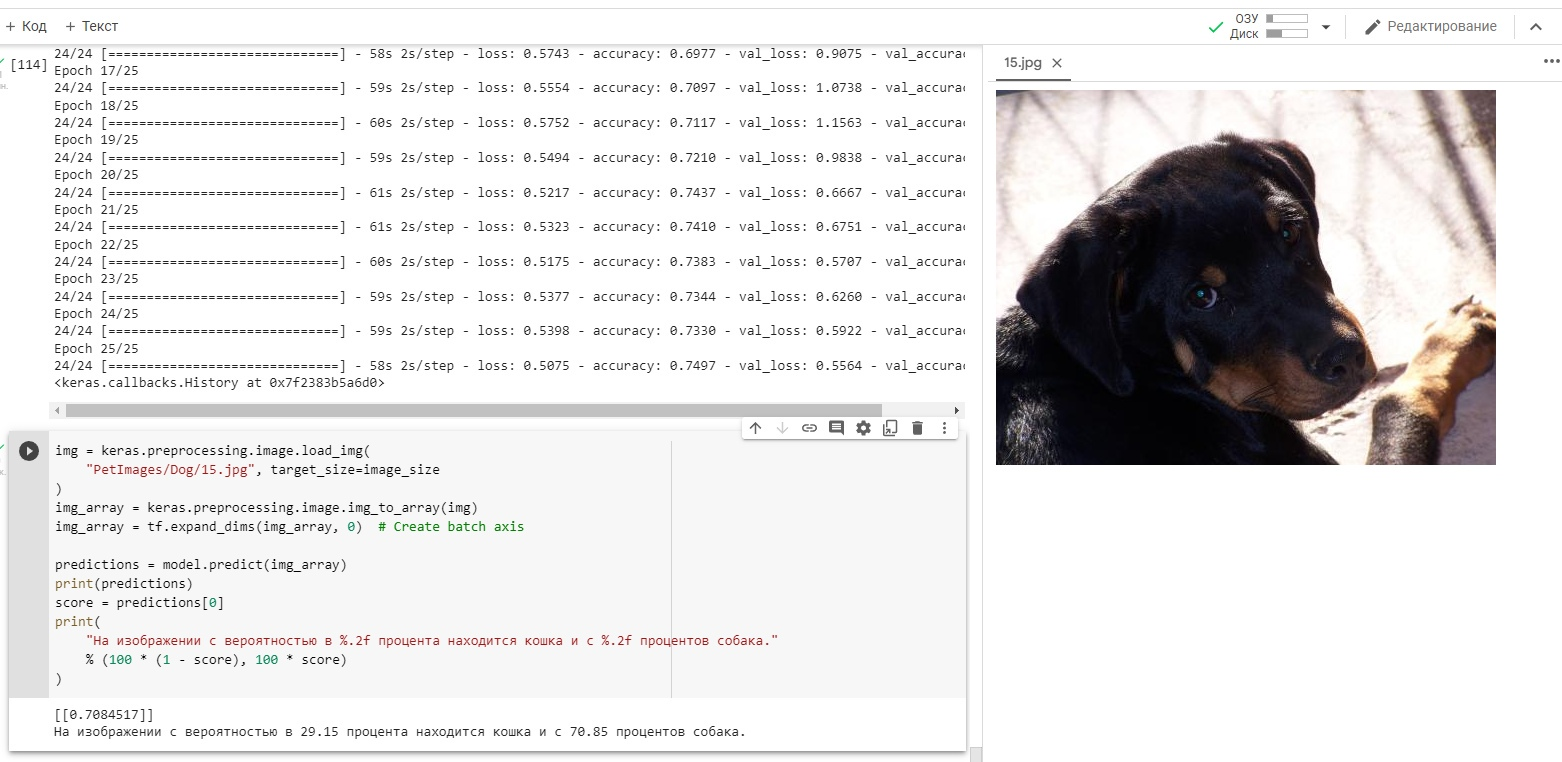

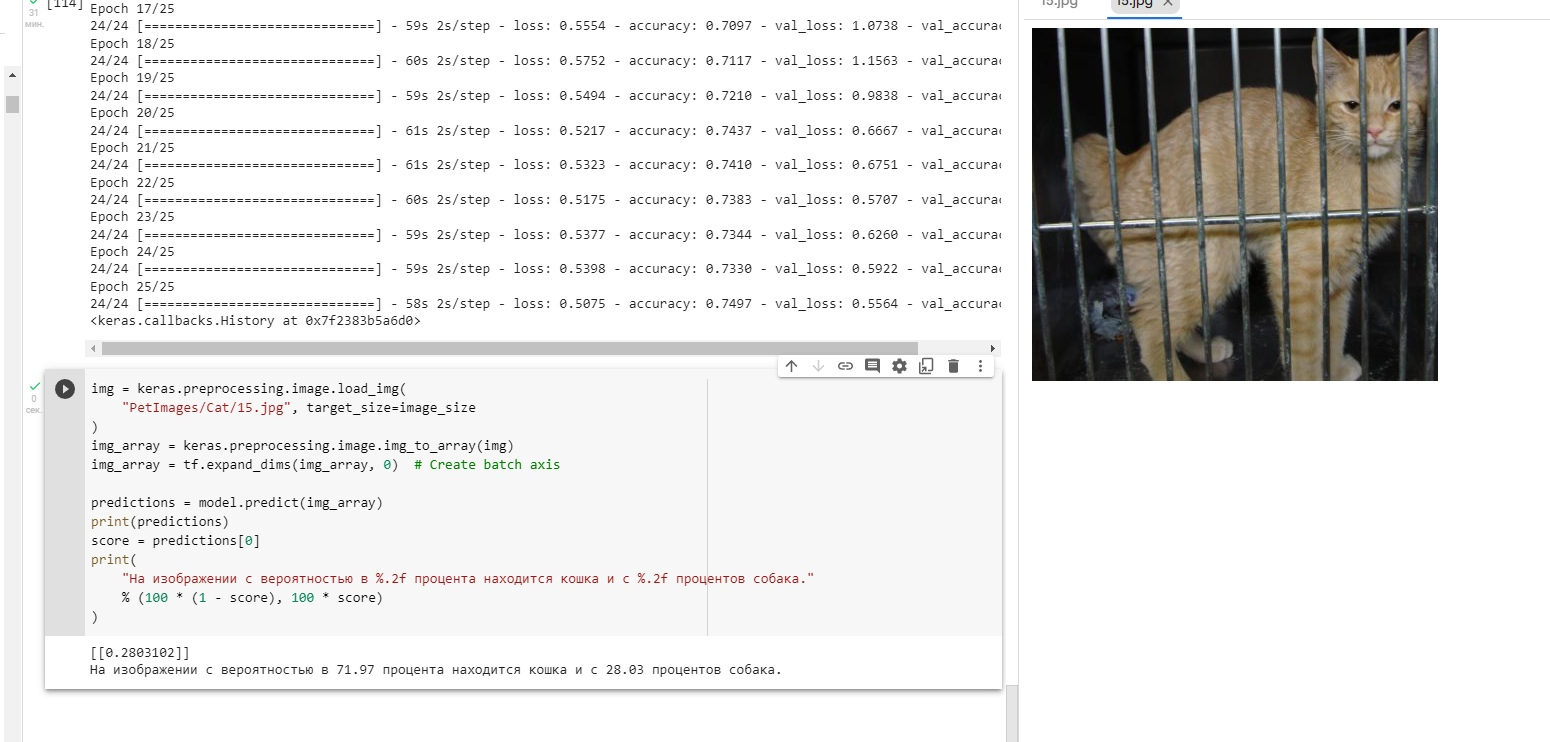